## Task 6: Train a Support Vector model to identify pedestrians

### Use Histogram of Gradients (HoG) as feature vectors
---------------------------------------------------------------------------------------------
Author: Rajesh Siraskar Created: 26-Dec-2018

- 26-Dec-2018: First version - extended from Task 4 (Random Forests' model)
- 09-Jan-2019: Second version. Extended from the Random Forests HoG version

**Objective:**
- Train an sklearn SVM on **HoG feature vectors** generated using the HoG function

**Instructions:**
- Use a balanced 70/30 train/test split
- Read the files appearing in the output train/test lists and store them as image matrices
- Process these with your HOG descriptor function before passing the resulting vectors to the classifier
- Use the Sklearn default parameters for the sklearn class for this task
- Report on performance on the 30% split
- Repeat this with different random splits and report the mean accuracy on the 30% ‘test’ sets

In [1]:
reset -f

In [22]:
## Imports

# Plot images inline with document
%matplotlib inline

# Import standard modules
import cv2            # OpenCV 
import numpy as np    # N dimensional array handling
import random         # random shuffling
import glob           # file handling
import seaborn as sns # graphics 
from matplotlib import pyplot as plt    # displaying images and plots
from sklearn.externals import joblib    # object serialization
from sklearn import metrics             # classification metrics
from sklearn.model_selection import cross_val_predict # for cross validation

from sklearn.svm import SVC # Support vector classifier

# Import custom functions
from SplitInstancesIntoTrainingAndTestSets import SplitInstancesIntoTrainingAndTestSets
from HoG_V2 import HoG_V2

### Create training and test sets
- Create class balanced training and test sets
- Read the image files as numpy pixel arrays

In [3]:
## Set top level parameters

# Image folders
path_positive = 'images/training_positive_instances/'
path_negative = 'images/training_negative_instances/'
file_type = '*.png'

# Limit training instances for experimentation
LIMIT_INSTANCES = False

In [4]:
train_set, test_set = SplitInstancesIntoTrainingAndTestSets(path_positive, path_negative)

Positive instances:  3070
Negative instances:  2371
Minimum instances for class balancing:  2371
CHECK: Classes balanced. Number of instances in both:  2371

SPLIT DATA SET
- Total instances: 4742
- Training instances: 3319
- Test instances: 1423


SplitInstancesIntoTrainingAndTestSets() returns a list of tuples: format is ('class', 'image_file_name')

In [5]:
# Import all training image files and read into image arrays
train_image_files = []
train_labels = []

# Move through the test_set list of tuples to separate out the file names
train_image_files = [files for (labels, files) in train_set]

# Next, separate out the class labels from train_set list of tuples
train_labels = [labels for (labels, files) in train_set]

In [6]:
# Import all testing image files and read into image arrays
test_image_files = []
test_labels = []

# test_set is a list of tuples: format is ('class', 'image_file_name')

# Move through the test_set list of tuples to separate out the file names
test_image_files = [files for (labels, files) in test_set]

# Next, separate out the class labels from test_set list of tuples
test_labels = [labels for (labels, files) in test_set]

**Convert labels to binary representations**

positive = 1
negative = 0

In [7]:
y_test = [1 if 'positive' in label else 0 for label in test_labels]
y_train = [1 if 'positive' in label else 0 for label in train_labels]

## Limit instances for quick experimentation

In [8]:
# If limited then take only 100 total instances, 70 training and 30 testing

if (LIMIT_INSTANCES and len(train_image_files) >= 70 and len(test_image_files) >= 30): 
    n_train = 70
    n_test = 30
    
    train_image_files = train_image_files[0:n_train]
    y_train = y_train[0:n_train]

    test_image_files = test_image_files[0:n_test]
    y_test = y_test[0:n_test]
    
    print('\n *** WARNING: Limited data-set being used')

## Gather the training and test images based on the file names

In [9]:
# Move through all .png files in folder and append to a local array of images
train_images = np.array([np.array(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)) 
                            for image_file in train_image_files])

In [10]:
# Move through all .png files in folder and append to a local array of images
test_images = np.array([np.array(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)) 
                            for image_file in test_image_files])

### Assign the image height and width to variables that will be used as testing view ports

In [11]:
# Default positive size: 216x82 pixels
training_image_H = train_images.shape[1]
training_image_W = train_images.shape[2]

### Show random sample of images to test import

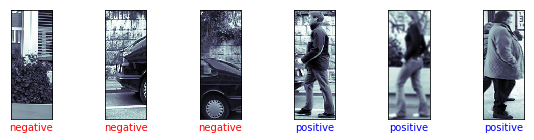

In [12]:
# Show few images to test import  
fig, axes = plt.subplots(1, 6, figsize=(10, 2),
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    index = random.sample(range(len(train_images)-1),1)[0]
    sample_image = train_images[index]
    class_label = train_labels[index]
    ax.imshow(sample_image, cmap='bone')
    ax.set(xticks=[], yticks=[], xlabel=class_label)
    ax.set(xticks=[], yticks=[], xlabel=class_label)
    if (class_label == 'positive'): ax.xaxis.label.set_color('blue')
    if (class_label == 'negative'): ax.xaxis.label.set_color('red')

In [13]:
# Check dimensions of original images array
print('NumPy Array of TRAINING images created. Shape:', train_images.shape)

# Flatten them to suit manipulation
# Find number of images and it's dimensions

n_images = len(train_images)
n_image_height = train_images[0].shape[0]
n_image_width = train_images[0].shape[1]

# Flatten 2-D images into singlular rows of data (1-D)
X_train = train_images.flatten().reshape(n_images, n_image_height*n_image_width)

print('Flattened array of images. Shape:', X_train.shape)

NumPy Array of TRAINING images created. Shape: (3319, 216, 82)
Flattened array of images. Shape: (3319, 17712)


In [14]:
# Check dimensions of original images array
print('NumPy Array of TEST images created. Shape:', test_images.shape)

# Flatten them to suit manipulation
# Find number of images and it's dimensions
n_images = test_images.shape[0]
n_image_height = test_images.shape[1]
n_image_width = test_images.shape[2]

# Flatten 2-D images into singlular rows of data (1-D)
X_test = test_images.flatten().reshape(n_images, n_image_height*n_image_width)

print('Flattened array of images. Shape:', X_test.shape)

NumPy Array of TEST images created. Shape: (1423, 216, 82)
Flattened array of images. Shape: (1423, 17712)


## Save data for re-use later

**pickel** allows serialising objects in binay format.

This allows string the data and models created above for later re-use. This will reduce duplication of Notebook code for subsequent Notebooks

In [15]:
# Save the image data for re-use later
joblib.dump(train_images, 'serialised_model_data/train_images.pkl')
joblib.dump(train_labels, 'serialised_model_data/train_labels.pkl')
joblib.dump(X_train, 'serialised_model_data/X_train.pkl')
joblib.dump(y_train, 'serialised_model_data/y_train.pkl')

joblib.dump(test_images, 'serialised_model_data/test_images.pkl')
joblib.dump(test_labels, 'serialised_model_data/test_labels.pkl')
joblib.dump(X_test, 'serialised_model_data/X_test.pkl')
joblib.dump(y_test, 'serialised_model_data/y_test.pkl')

print('\n Training and test data serialized')


 Training and test data serialized


## Create Histogram of Gradients (HoG) as feature vectors

**Parameters**:

- cell_size: size of cell in nxn pixels (default (8, 8))
- block_cells: multiplier i.e. m cells high and wide (default=2) 
- step_cells: number of cells by which a step is made while scanning bounding box left to right and top to bottom (default=1)
- num_bins: number of 'directional' (bins of direction i.e. angle of the gradient vectors) (default = 9)

In [16]:
n_images = test_images.shape[0]
n_image_height = test_images.shape[1]
n_image_width = test_images.shape[2]

image_size = (n_image_height, n_image_width)

# Cell size of 8 pixels x 8 pixels
cell_size = (8, 8)

# Block size of 2x2 cells
block_size =   2

# Block stride - can move say one cell at a time, scanning left to right and top to bottom
block_stride = 1

# Number of 'directional' bins: 180 degs./20 deg bins = 9 bins
num_bins = 9

# Filtering Options 'BILATERAL', 'GAUSSIAN' 
# For Gaussian: All three parameters (ksize.width, ksize.height) and sigma assumed to take the value filter_param
# For Bilateral: filter_param = Sigma values
# Sigma values: Small (< 10), filter will not have much effect, if large (> 150), 
#     = > strong effect, making the image look sketch like/cartoonish
    
apply_filter = 'BILATERAL'
filter_param = 120

print('\n HoG Parameters')
print('   image_size:', image_size)
print('   cell_size:', cell_size)
print('   block_size:', block_size)
print('   block_stride:', block_stride)
print('   num_bins:', num_bins)
print('   apply_filter:', apply_filter)
print('   filter_param:', filter_param)


 HoG Parameters
 image_size: (216, 82)

 HoG Parameters
   image_size: (216, 82)
   cell_size: (8, 8)
   block_size: 2
   block_stride: 1
   num_bins: 9
   apply_filter: BILATERAL
   filter_param: 120


In [17]:
%%time
train_hog_features = [HoG_V2(img, apply_filter=apply_filter, filter_param=filter_param) for img in train_images] 
test_hog_features = [HoG_V2(img, apply_filter=apply_filter, filter_param=filter_param) for img in test_images] 
print('\n - Training and test data HoG features created.')


 - Training and test data HoG features created.
Wall time: 28min 20s


In [18]:
X_train = np.array(train_hog_features)
X_test = np.array(test_hog_features)
print('train data:', X_train.shape)
print('test data:', X_test.shape)

train data: (3319, 1152, 1)
test data: (1423, 1152, 1)


In [19]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
print('train data:', X_train.shape)
print('test data:', X_test.shape)

train data: (3319, 1152)
test data: (1423, 1152)


### Create a Support Vector Machine (SVM) classifier and train it

In [23]:
%%time
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)
print('\n - SVM Model trained on HoG features')


 - SVM Model trained on HoG features
Wall time: 12.6 s


In [24]:
y_predicted = svm_classifier.predict(X_test)
y_scores = svm_classifier.predict_proba(X_test)[:, 1]

## Classification Results
1. Precision, Recall and F1-scores
2. Confusion matrix

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       716
          1       0.99      0.99      0.99       707

avg / total       0.99      0.99      0.99      1423



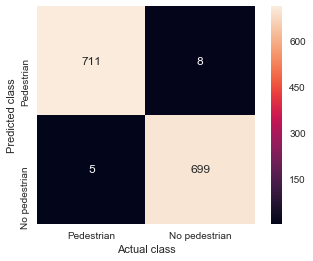

In [25]:
print(metrics.classification_report(y_test, y_predicted))

mat = metrics.confusion_matrix(y_test, y_predicted)

# Show heat-map with totals in integer format
sns.set()  #  set to seaborn defaults
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=['Pedestrian','No pedestrian'], yticklabels=['Pedestrian','No pedestrian'])
plt.xlabel('Actual class')
plt.ylabel('Predicted class');

In [26]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores)
average_precision = metrics.average_precision_score(y_test, y_scores)
AUC_score = metrics.roc_auc_score(y_test, y_scores)

print('Average precision-recall score: {0:0.3f}'.format(average_precision))
print('Area under the ROC curve:       {0:0.3f}'.format(AUC_score))

Average precision-recall score: 1.000
Area under the ROC curve:       1.000


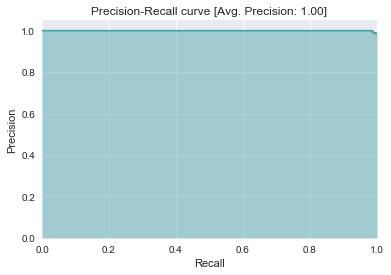

In [27]:
plt.step(recalls, precisions, color='#49a4aa')
plt.fill_between(recalls, precisions, alpha=0.45, color='#49a4aa')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.00])
plt.title('Precision-Recall curve [Avg. Precision: {0:0.2f}]'.format(average_precision))

plt.show()

In [28]:
# Pastel colors: 
# Blue #002BA1 Sea-green: #49a4aa. Dark red: #c90000. Light-purple-red 

# Ref.: Aurelien Geron Hands-on Machine Learning with Scikit Learn and TensorFlow pg:89
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], linestyle = 'solid', color='#49a4aa', label='Precision')
    plt.plot(thresholds, recalls[:-1], linestyle = 'solid', color='#b86b77', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([0,1])

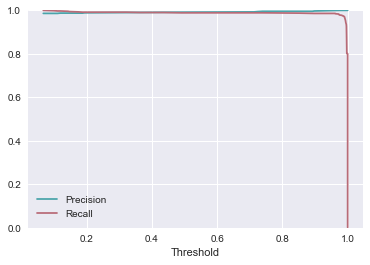

In [29]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Store model for future testing or re-use

In [31]:
# Save the model for reuse later

joblib.dump(svm_classifier, 'serialised_model_data/svm_model_HoG.pkl')
print('\n SVM model serialized')


 SVM model serialized
